In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
q1 = cv2.imread('q1.png', cv2.IMREAD_GRAYSCALE)
img = cv2.imread('q3.png')
melanome1 = cv2.imread('melanome1.jpg', cv2.IMREAD_GRAYSCALE)
melanome2 = cv2.imread('melanome2.jpg', cv2.IMREAD_GRAYSCALE)
melanome3 = cv2.imread('melanome3.jpg', cv2.IMREAD_GRAYSCALE)
melanome4 = cv2.imread('melanome4.jpg', cv2.IMREAD_GRAYSCALE)

## 1

### A

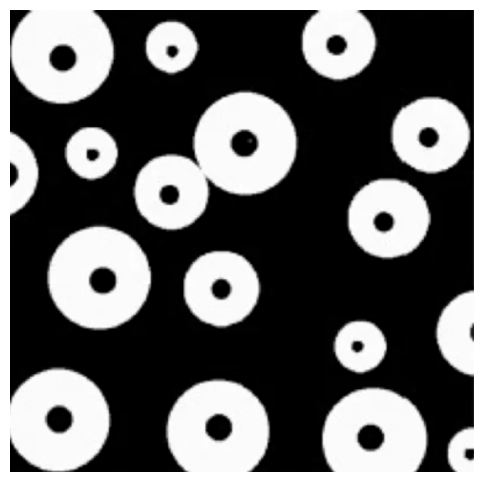

In [3]:
plt.figure(figsize=(6,6))
plt.imshow(q1, cmap='gray')
plt.axis('off')
plt.show()

### B

In [4]:
kernel_size = 50 # 2 dimensions
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
closed_img = cv2.morphologyEx(q1, cv2.MORPH_CLOSE, kernel)

- Since hole shapes are circle, I use elliptical kernel. 
- With some hit-and-miss, I tried to find the accurate kernel size that removes all holes.
- Since the goal is to remove holes, I need to use a closing filter that retains peaks and omits holes.
- Closing is Dilation followed by Erosion

### C

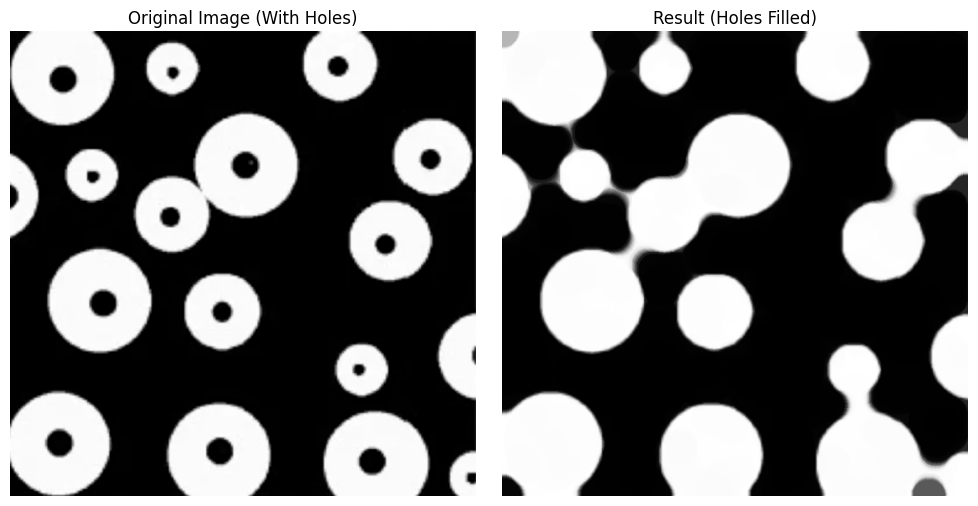

In [5]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(q1, cmap='gray')
plt.title('Original Image (With Holes)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(closed_img, cmap='gray')
plt.title('Result (Holes Filled)')
plt.axis('off')

plt.tight_layout()
plt.show()

As seen, all holes are removed. However, as discussed in the report, dilation causes some unwanted connections between nearby white circles which can not be removed by erosion. 

We should use hole fitting:
    $$X_k = (X_{k-1} \oplus B) \cap A^c$$
    
- $X_0$ (The Marker): The algorithm starts with a seed point (usually the border of the image or a point inside a hole).
- $\oplus B$ (Dilation): The seed grows (dilates).
- $\cap A^c$ (Intersection): This is the key. The dilation is intersected with the mask. This forces the growing region to stop exactly at the boundaries of the original object. It cannot spill over the edge.

## 2

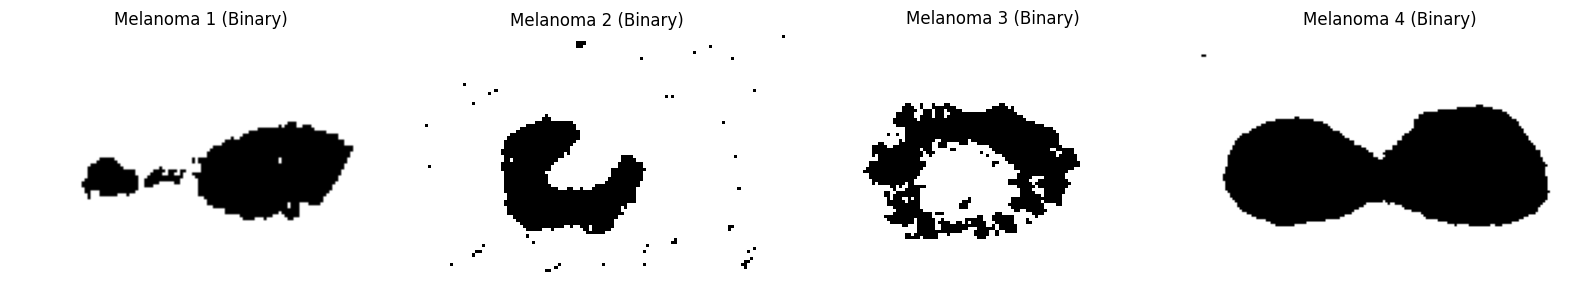

In [6]:
img_array = [melanome1, melanome2, melanome3, melanome4]

# Thresholding (0.25 * 255 = 63.75 -> rounded to 64)
thresh_val = 64
binary_images = []
for img in img_array:
    _, bin_img = cv2.threshold(img, thresh_val, 255, cv2.THRESH_BINARY)
    binary_images.append(bin_img)

plt.figure(figsize=(16, 5))

for i in range(4):
    plt.subplot(1, 4, i+1)

    plt.imshow(binary_images[i], cmap='gray')
    plt.title(f'Melanoma {i+1} (Binary)')
    plt.axis('off')

plt.tight_layout()
plt.show()

thresh_val: The threshold value.
- Any pixel in the image that is brighter (higher value) than this number will be treated as "object".
- Any pixel darker (lower value) will be treated as "background".

### A

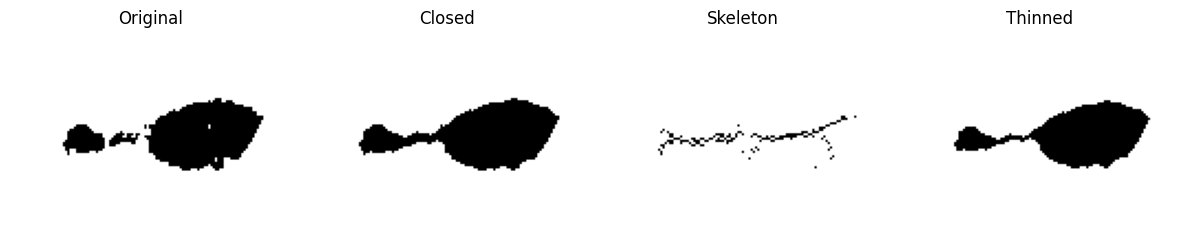

In [104]:
if np.mean(binary_images[0]) > 127:
    binary_img = cv2.bitwise_not(binary_images[0])
kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
closed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel_close)

skeleton = np.zeros(closed_img.shape, np.uint8)
img_temp = closed_img.copy()
element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

while True:
    eroded = cv2.erode(img_temp, element)
    temp = cv2.dilate(eroded, element)
    
    # This leaves just the "skeletal" ridge for this layer
    temp = cv2.subtract(img_temp, temp)
    
    # Add to result and erode it
    skeleton = cv2.bitwise_or(skeleton, temp)
    img_temp = eroded.copy()
    
    # Stop if the image is empty
    if cv2.countNonZero(img_temp) == 0:
        break

kernel_erode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
inner_parts = cv2.erode(closed_img, kernel_erode, iterations=1)

plt.figure(figsize=(12, 4))
titles = ['Original', 'Closed', 'Skeleton', 'Thinned']
images = [binary_img, closed_img, skeleton, inner_parts]

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(cv2.bitwise_not(images[i]), cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

Closing is Dilation followed by Erosion. It is used to fill small holes inside the object and connect nearby components without significantly changing the size of the object. Unless I used a small size of kernel, the connection between the left and right part would be cut.

After closing, since I want to have the inner parts, thinning is practical to use. I used a lower kernel size to make sure the connection between the two parts gets to remain.

### B

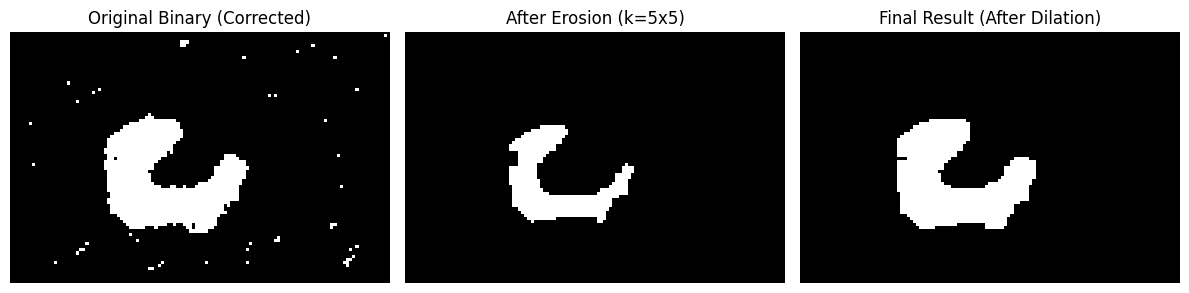

In [66]:
if np.mean(binary_images[1]) > 127:
    binary_img = cv2.bitwise_not(binary_images[1])

kernel_size = 5
kernel = np.ones((kernel_size, kernel_size), np.uint8)
eroded_img = cv2.erode(binary_img, kernel, iterations=1)
dilated_img = cv2.dilate(eroded_img, kernel, iterations=1)
final_lesion = dilated_img

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original Binary (Corrected)")
plt.imshow(binary_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title(f"After Erosion (k={kernel_size}x{kernel_size})")
plt.imshow(eroded_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Final Result (After Dilation)")
plt.imshow(final_lesion, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

Opening is Erosion followed by Dilation. It removes objects that are smaller than the structuring element. Since hairs are *thin* structures, an erosion step will completely remove them. The subsequent dilation restores the main lesion shape. However, I figured if I simply apply opening, the result would be exactly opposite from what I've done. Meaning: When eroding, the result appears as if I've dilated the image. So I used a code to reverse every single bit.

Kernel size is crucial. If I use a small size, it wouldn't be able to catch hairs, and if I use a large one, it would detect the target as noise as well.

### C

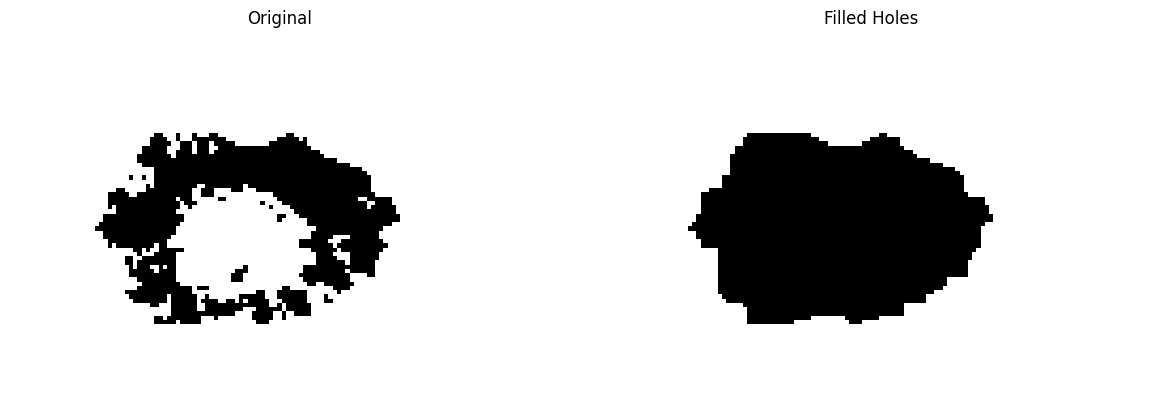

In [74]:
if np.mean(binary_images[2]) > 127:
    binary_img = cv2.bitwise_not(binary_images[2])
    
kernel = np.ones((7,7), np.uint8) 
closed_binary_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)
growth_mask = cv2.bitwise_not(closed_binary_img) # return to original color

X = np.zeros_like(closed_binary_img)
X[0, 0] = 255

kernel = np.ones((3, 3), np.uint8)

while True:
    prev_X = X.copy()
    
    # Apply Formula: Dilation AND Mask
    X = cv2.dilate(X, kernel)
    X = cv2.bitwise_and(X, growth_mask)
    
    # Stop if no change
    if np.array_equal(X, prev_X):
        break

plt.figure(figsize=(12, 4))
titles = ['Original', 'Filled Holes']
images = [binary_images[2], X]

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

First, We need to use closing. This is because the boundaries are not continuous and required dilation to have a consistent boundary. In order to preserve the shape and the size, erosion is used. Therefore, we use closing.

$X_0$: We assume the top-left corner is background.
 
- $M$: The constraint that limits the growth. Since we want to grow the background, the walls that stop the flood are the object pixels. Therefore, the mask is the complement of the closed image.
$$\[M = (I_{closed})^c\]$$
In this mask, the background is White and the Object is Black.

Structuring Element ($B$): A small kernel for iterative growth.


We iteratively dilate the marker $X$ and constrain it using the intersection with the mask $M$. The update rule for the $k$-th iteration is:

$X_k = (X_{k-1} \oplus B) \cap M\$

- Dilation ($X_{k-1} \oplus B$): Expands the known background region by one pixel in all directions.
- Intersection ($\cap M$): Prevents the expansion from crossing into the object (since the object pixels in $M$ are $0$).

This process repeats until $X_k = X_{k-1}$. 

Since $X_{\infty}$ contains all pixels connected to the image border (the background), any pixels that are not in $X_{\infty}$ must be either the object itself or the holes inside it. To get the final filled object, I invert the result:

$\[I_{filled} = (X_{\infty})^c\]$

This effectively converts the background to Black ($0$) and the object (plus its holes) to White ($1$).

### D

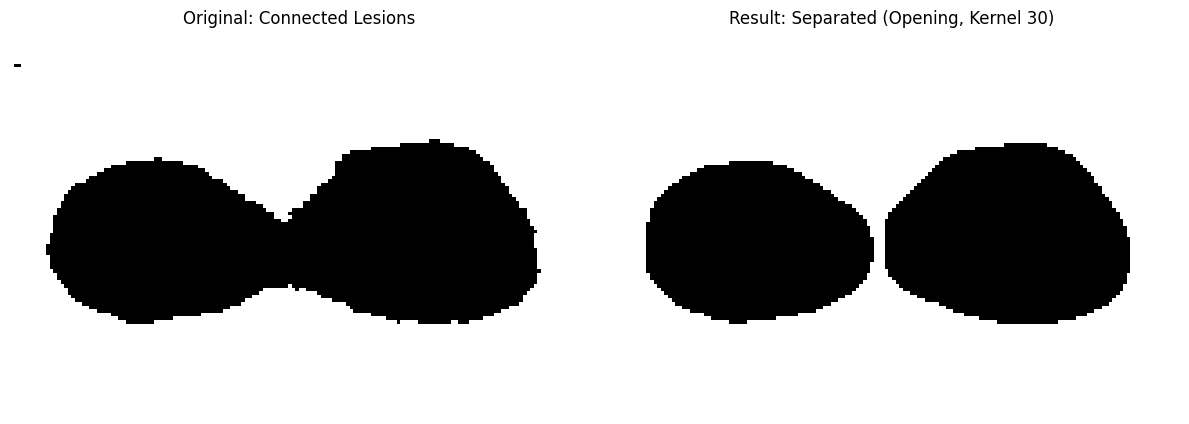

In [89]:
if np.mean(binary_images[3]) > 127:
    binary_img = cv2.bitwise_not(binary_images[3])
kernel_size = 30
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
separated_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel)
separated_img = cv2.bitwise_not(separated_img)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(binary_images[3], cmap='gray')
plt.title('Original: Connected Lesions')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(separated_img, cmap='gray')
plt.title(f'Result: Separated (Opening, Kernel {kernel_size})')
plt.axis('off')

plt.tight_layout()
plt.show()

Opening is required: erosion followed by dilation.

SE Requirement: Size must be larger than the width of the neck to catch it thoroughly.

## 3

### A

In [13]:
q3_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

lower_green = np.array([40, 50, 50])
upper_green = np.array([80, 255, 255])

mask = cv2.inRange(q3_hsv, lower_green, upper_green)

cv2.imwrite('q3res01.jpg', mask)

True

why HSV? 

In the standard BGR format, a "green" pixel isn't just in the Green channel; it is affected by light and shadow, spreading the data across Blue and Red too. This makes it hard to say "find all green things.

Hue (First number): In OpenCV, Hue ranges from 0 to 179. Green is usually around 60. I set the range from 40 to 80 to catch different shades of green (yellowish-green to bluish-green).

Saturation & Value (Second and third numbers):
- Lower (50, 50): We ignore very gray or very dark pixels.
- Upper (255, 255): We accept the most intense and brightest versions of the color. (Since the green color is really bright in the picture)

Then, IF the pixel is inside the range (Hue 40-80, Sat > 50, Val > 50) → Turn pixel White (255).

### B

In [ ]:
kernel_open = np.ones((5, 5), np.uint8)
mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_open)
contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(mask_clean, contours, -1, (255), thickness=cv2.FILLED)

cv2.imwrite('q3res02_final.jpg', mask_clean)

The optimum kernel size is 7. With an increase in its size, the mask gets worse, and with a reduction, black dots won't be removed. Nevertheless, the leg of the wine glass that holds it is also removed.

So, I refused using ordinary opening/ closing filters and used hole fitting. I found the boundaries and filled the area in it.

The simple version:

In [ ]:
kernel = np.ones((7, 7), np.uint8)
mask_opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask_closed = cv2.morphologyEx(mask_opened, cv2.MORPH_CLOSE, kernel)

cv2.imwrite('q3res02.jpg', mask_closed)

### C (Concessionary)

In [ ]:
img[mask_clean == 255] = [0, 0, 255]
cv2.imwrite('q3res03.jpg', img)

Nothing special!
I only changed the color intensity so that it turns red.